# Unsupervised sentence embedding learning - SimCSE

In this notebook we will implement [SimCSE](https://arxiv.org/pdf/2104.08821.pdf) by `Tianyu Gao, Xingcheng Yao and Danqi Chen`
, a simple contrastive learning framework that works with both unlabeled and labeled data.

> Unsupervised SimCSE simply takes an input sentence and predicts itself in a contrastive learning framework, with only standard dropout used as noise. Our supervised SimCSE incorporates annotated pairs from NLI datasets into contrastive learning by using entailment pairs as positives and contradiction pairs as hard negatives. The following figure is an illustration of our models.
>
> Source: https://github.com/princeton-nlp/SimCSE

In TSDAE, the authors use aggresive deletion as the strategy for noise, here we depend on the dropout in the Transformer encoder architecture as noise. Essentially we pass the same sentence twice through the model(model set in the the `train()` mode) and after pooling we get slightly different embeddings. We then use the MNR loss over a batch of these embedding pairs to finetune the model.

| ![](assets/simcse.png) | 
|:--:| 
| Fig. 1. Illustration of the training process of SimCSE(BERT model in the train() mode). |

We will use a subset of the snli dataset to train an encoder for generating sentence embeddings using the unsupervised method descibed in SimCSE. We will use the MNR loss.

> This loss expects as input a batch consisting of sentence pairs (a_1, p_1), (a_2, p_2)..., (a_n, p_n) where we assume that (a_i, p_i) are a positive pair and (a_i, p_j) for i!=j a negative pair.
>
> For each a_i, it uses all other p_j as negative samples, i.e., for a_i, we have 1 positive example (p_i) and n-1 negative examples (p_j). It then minimizes the negative log-likehood for softmax normalized scores. This loss function works great to train embeddings for retrieval setups where you have positive pairs (e.g. (query, relevant_doc)) as it will sample in each batch n-1 negative docs randomly.
>
> The performance usually increases with increasing batch sizes.
>
> For more information, see: https://arxiv.org/pdf/1705.00652.pdf<br>
(Efficient Natural Language Response Suggestion for Smart Reply, Section 4.4)
>
> You can also provide one or multiple hard negatives per anchor-positive pair by structering the data like this: (a_1, p_1, n_1), (a_2, p_2, n_2)
>
> Here, n_1 is a hard negative for (a_1, p_1). The loss will use for the pair (a_i, p_i) all p_j (j!=i) and all n_j as negatives.
>
> Source: https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py

We will just use the (anchor, postive) pairs in our training here. We will discuss hard negatives later in the series.

Since we just need the (achor, positive) pairs, we will filter the snli dataset with label=0 for entails.

In [1]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import BertTokenizerFast, BertModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sentence_transformers import util
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

Let's start ...

## Data preparation

We will create a custom dataset for the that will give us postive and negative pairs.

In [3]:
dataset = datasets.load_dataset("snli", split="train")

# there are some pairs of "premise" and "hypothesis" which haven't been
# labeled in this dataset, we will filter those out first
dataset = dataset.filter(lambda x: True if random.random() > 0.95 else False)

len(dataset), dataset[0]

Reusing dataset snli (/home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Parameter 'function'=<function <lambda> at 0x7f407b992940> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/551 [00:00<?, ?ba/s]

(27524,
 {'premise': "Woman in white in foreground and a man slightly behind walking with a sign for John's Pizza and Gyro in the background.",
  'hypothesis': 'A woman ordering pizza.',
  'label': 1})

Let's look at the distribution of the lengths of the sentences in our dataset to pick the max_length for our tokenizer.

In [4]:
preimse_lengths = []

for data in tqdm(dataset):
    if random.random() > 0.9:
        preimse_lengths.append(len(data["premise"]))

100%|████████████████████████████████████████████████████████████████| 27524/27524 [00:01<00:00, 18777.55it/s]


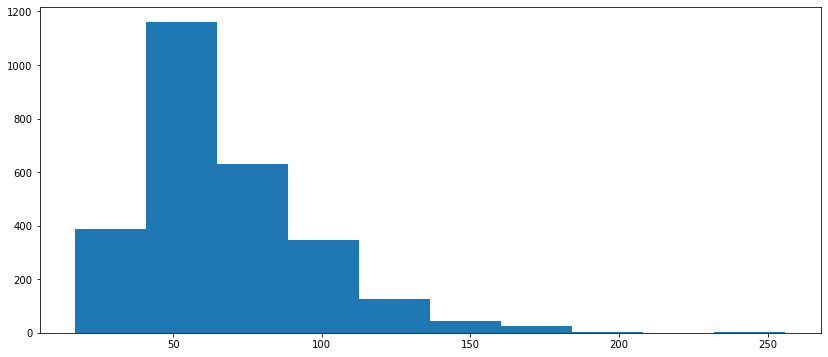

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(preimse_lengths);

In [6]:
%%time

MAX_LENGTH = 128

# anchors
tokenized_premises = tokenizer([data["premise"] for data in dataset],
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True, return_tensors="pt")

CPU times: user 4.32 s, sys: 792 ms, total: 5.11 s
Wall time: 2.91 s


In [7]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Now we will create out custom dataset and dataloaders with train/validation split for training.

In [8]:
class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict):
        self.premise_tokens = premise_tokens

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {"input_ids": self.premise_tokens["input_ids"][ix],
                "attention_mask": self.premise_tokens["attention_mask"][ix]}

    def __len__(self) -> int:
        return len(self.premise_tokens["input_ids"])

In [9]:
%%time

snli_dataset = SnliDataset(tokenized_premises)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [10]:
train_ratio = 0.8
n_total = len(snli_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(snli_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
next(iter(train_dataloader))

{'input_ids': tensor([[ 101, 2048, 4004,  ...,    0,    0,    0],
         [ 101, 1037, 2450,  ...,    0,    0,    0],
         [ 101, 2048, 2273,  ...,    0,    0,    0],
         ...,
         [ 101, 1037, 2158,  ...,    0,    0,    0],
         [ 101, 2048, 3455,  ...,    0,    0,    0],
         [ 101, 1037, 2158,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

## Model config

Here we will setup out custom SBERT model as detailed in the diagram from the paper.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The method mean_pool() implements the mean token pooling strategy mentioned in the paper. The implementation has been picked up from the sentente_transformers library.

We will use the encode() method to compute pooled embeddings using the finetuned and the bert-base models later to evaluate the results on STS tasks.

In [13]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(
    input_texts: list[str], tokenizer: BertTokenizerFast, model: BertModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=MAX_LENGTH,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [14]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


    def forward(self, data: datasets.arrow_dataset.Dataset) -> tuple[torch.tensor, torch.tensor]:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)

        out_premise = self.bert_model(input_ids, attention_mask)
        embeds1 = out_premise.last_hidden_state
        out_premise = self.bert_model(input_ids, attention_mask)
        embeds2 = out_premise.last_hidden_state

        pooled_embeds1 = mean_pool(embeds1, attention_mask)
        pooled_embeds2 = mean_pool(embeds2, attention_mask)

        return pooled_embeds1, pooled_embeds2

In [15]:
model = Sbert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
model = model.to(device)

## Training loop

While calculating the loss per batch, using the similarity matrix(from anchors and positives) and the target tensor, we scale the similarty matrix by a constant first. We are using a scaling factor of 20 as used in the sentence_tranformer library.

The reason for this scaling(from what i can tell) is the same as using temperature while decoding from seq2seq models. Essentially we want to make the distribution of scores(similarity in this case) more peaky(this amouts to lowering the temperature while decoding).

For example, consider a batch size 4 with similarity scores [0.8, 0.75, 0.5, 0.4] with `similarity(anchor, positve)` = 0.8.

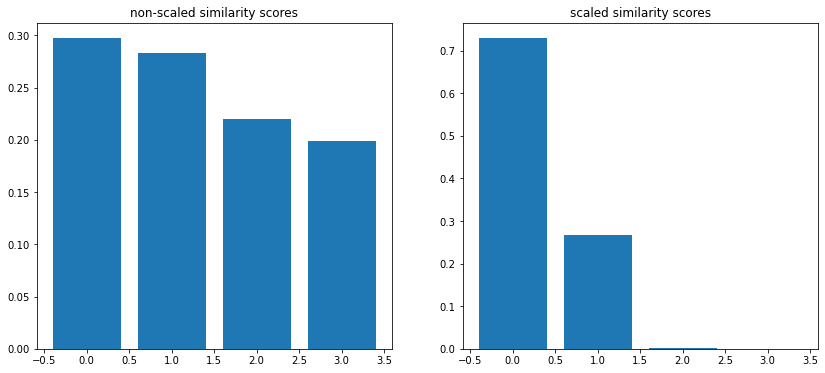

In [18]:
similarity_scores = np.array([0.8, 0.75, 0.5, 0.4])
softmax_scores = np.exp(similarity_scores) / np.exp(similarity_scores).sum()
scaled_softmax_scores = np.exp(similarity_scores*20) / np.exp(similarity_scores*20).sum()

fix, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(range(len(softmax_scores)), softmax_scores)
ax[0].set_title("non-scaled similarity scores")
ax[1].bar(range(len(scaled_softmax_scores)), scaled_softmax_scores)
ax[1].set_title("scaled similarity scores");

In [19]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer, 
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor], float]:

    def train_step_fn(x: torch.tensor) -> float:
        model.train()
        anchor_encodings, positive_encodings = model(x)
        similarity_matrix = util.cos_sim(anchor_encodings, positive_encodings)
        target = torch.tensor(range(len(anchor_encodings)), dtype=torch.long, device=device)
        loss = loss_fn(similarity_matrix * 20, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor], float]:

    def val_step_fn(x: torch.tensor) -> float:
        model.eval()
        anchor_encodings, postiive_encodings = model(x)
        similarity_matrix = util.cos_sim(anchor_encodings, postiive_encodings)
        target = torch.tensor(range(len(anchor_encodings)), dtype=torch.long, device=device)
        loss = loss_fn(similarity_matrix * 20, target)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader, step_fn: Callable[[torch.tensor], float], is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data)
        mini_batch_losses.append(loss)
        if i % (batch_size * 20) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [20]:
%%time

n_epochs = 1

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/1377, loss =  0.130
step   320/1377, loss =  0.000
step   640/1377, loss =  0.000
step   960/1377, loss =  0.000
step  1280/1377, loss =  0.000

Validating ...
step     0/345, loss =  0.000
step   320/345, loss =  0.000
CPU times: user 3min 16s, sys: 57.7 s, total: 4min 14s
Wall time: 4min 14s


In [21]:
train_loss, val_loss

(0.002556561377214833, 2.7032296759938144e-05)

Normally we look at losses over multiple epochs, but here we have only 1 epoch. One way to look at the mini batch losses is to use a running mean(smoothing) to reduce noise from per batch loss.

In [22]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

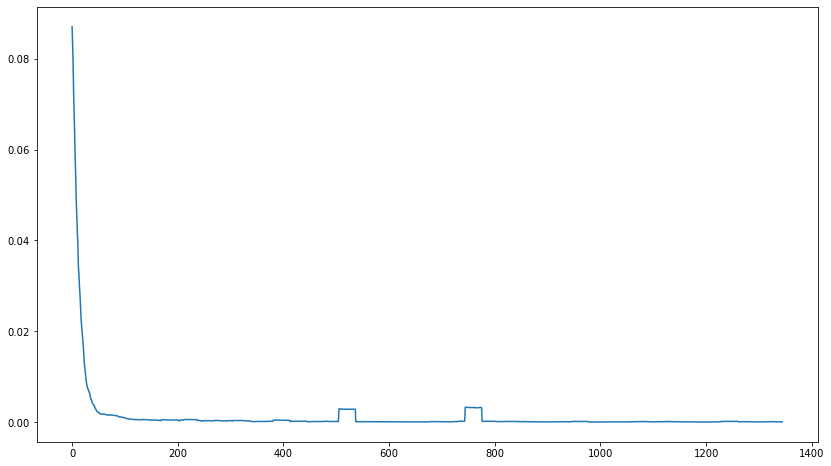

In [23]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

## Evaluation

Here we will manually inspect the performance of our finetuned model as well as use a STS dataset for evaluation on a similar task as mentioned in the paper.

For manual inspection, we have taken few texts which fall neatly into three clusters. We want to see how neatly our finetuned model(and the bert-base model) is able to find these clusters.

In [24]:
def plot_heatmap(similarity_matrix: np.array, sentences: List[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

In [25]:
sentences = [
    "What should I do to improve my English ?",
    "What should I do to improve my spoken English?",
    "Can I improve my English?",
    "How can I earn money online?",
    "How do I earn money online?",
    "Can I earn money online?",
    "What are some mind-blowing Mobile gadgets that exist that most people don't know about?",
    "What are some mind-blowing gadgets and technologies that exist that most people don't know about?",
    "What are some mind-blowing mobile technology tools that exist that most people don't know about?"
]

In [26]:
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

Our finetuned model.

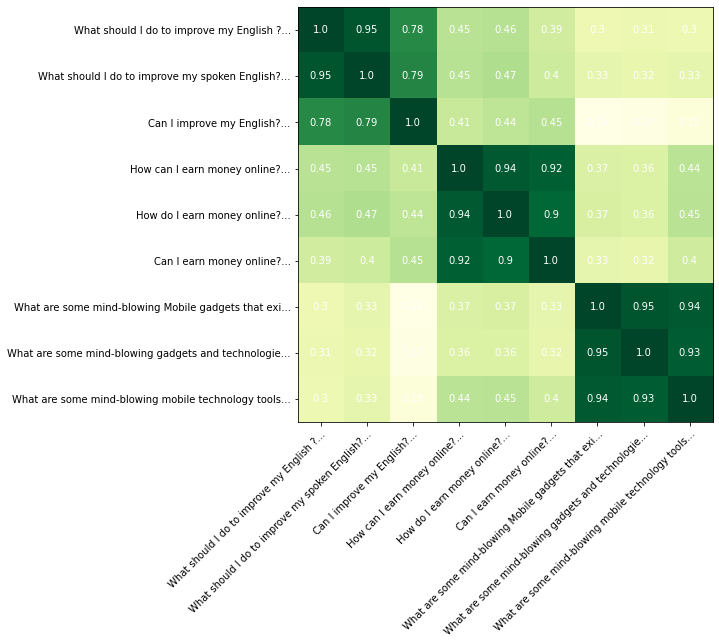

In [27]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

Next we import the original bert-base model again for comparison.

In [28]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
pooled_embeds = encode(sentences, tokenizer, bert_model, "cpu")
pooled_embeds = pooled_embeds.detach().numpy()

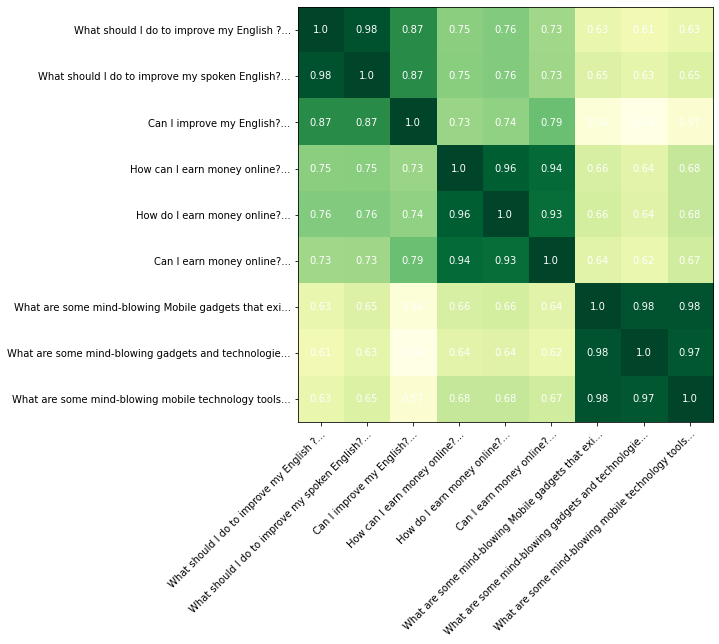

In [30]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

On a visual inspection we can see that our finetuned model is doing a better job in encoding the texts so that the clusters are clearly visible. Specifically it's doing a better job in pusing down the scores for non similar text pairs.

Let's evaluate the models on a STS dataset.

In [31]:
sbert_model = model.bert_model
bert_model = bert_model.to(device)

In [32]:
sts = datasets.load_dataset("glue", "stsb", split="validation")
len(sts), sts[0]

Reusing dataset glue (/home/utsav/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


(1500,
 {'sentence1': 'A man with a hard hat is dancing.',
  'sentence2': 'A man wearing a hard hat is dancing.',
  'label': 5.0,
  'idx': 0})

In [33]:
sentence1s = [data["sentence1"] for data in sts]
sentence2s = [data["sentence2"] for data in sts]
normalized_labels = [data["label"] / 5 for data in sts]

In [34]:
def cos_sim_in_batches(
    batch_size: int, s1_texts: list[str], s2_texts: list[str],
    tokenizer: BertTokenizerFast, model: BertModel,
    cos_sim_f: Callable[[torch.tensor, torch.tensor], torch.tensor]
) -> torch.tensor:

    cos_sims = None
    n_batches = len(s1_texts) // batch_size + int(len(s1_texts) % batch_size != 0)
    for i in range(n_batches):
        s1_batch = s1_texts[i*batch_size: (i+1)*batch_size]
        s2_batch = s2_texts[i*batch_size: (i+1)*batch_size]
        if i == 0:
            cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, "cuda").detach(),
                                 encode(s2_batch, tokenizer, model, "cuda").detach())
        else:
            _cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, "cuda").detach(),
                                  encode(s2_batch, tokenizer, model, "cuda").detach())
            cos_sims = torch.cat([cos_sims, _cos_sims])
    
    return cos_sims

In [35]:
cos_sim_f = torch.nn.CosineSimilarity()
sbert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, sbert_model, cos_sim_f)
bert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, bert_model, cos_sim_f)

In [36]:
stats.spearmanr(sbert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.7535440057938854, pvalue=3.49275227046797e-275)

In [37]:
stats.spearmanr(bert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.5931769556210932, pvalue=3.0261969816970313e-143)

The authors report spearman rank correlation of `76.25` with `princeton-nlp/unsup-simcse-bert-base-uncased` model. We came pretty close with very little amount of training.

SimCSE works great with little training but it does not do well when used in the `adaptive pre-training` setting.

What is `adaptive pre-training` ?<br>
What we typically expect is to finetune a model on some labeled data(MS MARCO) and adapt it to our domain using unsupervised target domain training. This does not work out well in practice (https://arxiv.org/pdf/2104.06979, https://arxiv.org/pdf/2112.07577). What works is doing a pre-training on the target domain and then finetune the model on some labeled dataset(MS MARCO).

| ![](assets/pre_training.png) | 
|:--:| 
| Fig. 2. Results from adaptive pre-training. (Image source: https://www.youtube.com/watch?v=xbdLowiQTlk&t=1575s) |


---

## References

[1] Tianyu Gao, Xingcheng Yao and Danqi Chen. "[TSimCSE: Simple Contrastive Learning of Sentence Embeddings](https://arxiv.org/abs/2104.08821)"

[2] https://github.com/princeton-nlp/SimCSE

[3] https://github.com/UKPLab/sentence-transformers